# EXERCISE 08 - Planning a telescope observation

Let's build your first Markov Chain!

You are a real astronomer (not a theory guy like me) and are planning an expensive observational campaign. You want to know how likely it is that tomorrow night will be clear given the weather tonight (clear or cloudy). The key piece of information here is that the weather tomorrow depends on the weather today. From past history, you know that:

$p({\rm clear \; tomorrow} \, | \,  {\rm cloudy \; today}) = 0.5$,

which means that

$p({\rm cloudy \; tomorrow} \, |\, {\rm cloudy \; today}) = 0.5$.

We also have,

$p({\rm cloudy \; tomorrow} \, |\, {\rm clear \; today}) = 0.1$,

which means that,

$p({\rm clear \; tomorrow} \, |\, {\rm clear \; today}) = 0.9$.


- We can start with the sky conditions today and make predictions going forward more and more into the future.
- This will look like a big decision tree.
- After enough days, we'll reach equilibrium probabilities that have to do with the mean weather statistics (ignoring seasons) and we'll arrive at

$p({\rm clear}) = 0.83$,

and,

$p({\rm cloudy}) = 0.17$.

You get the same answer for day $N$ as day $N+1$ and it doesn't matter whether it was clear or cloudy on the day that you started. The steps that we have taken in this process are, indeed, a **MARKOV CHAIN**.

Here is an illustration of this process:

![image.png](https://miro.medium.com/max/416/1*frksGjINf5oTjx7WL81U3w.png)

## MODULES IMPORT

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import astroML.stats as astroMLstats

from astropy.visualization import hist

# L10:

## Tasks

- Start off on a cloud day.
- Implement your weather weather based on the above probabilities.
- Run your simulator for N days (with $N\gtrsim 10^4$).
- Prepare a plot with the number of days on the x axis and the cumulative fraction of, say, sunny days over the number of days so far on the y axis. This is called a **trace-plot**, showing how our estimate of $p(\mathrm{clear})$ evolves as the chain samples.
- Prepare a histogram of the above plot. This reveals the distribution of $p(\mathrm{clear})$.
- Use a summary statistics to determine the most likely value and an error on our estimate.
- In the above example, experiment with chopping off different numbers of initial points as burn-in.

**Important:**
- In MCMC the process must be **stationary** which basically means that the chain statistics look the same no matter which chunk you look at, e.g. first half, second half, or every other point, etc.
- Obviously that isn't going to be the case in the early steps of the chain. In our example above, after some time the process was stationary, but not in the first few days.
- So, there is a **burn-in** phase that needs to be discarded. How one determines the number of early steps to discard as burn-in is tricky, but ***you should always start with a traceplot of your samples!***


#### (Optional, not examinable) Finance

- Redo the same for the Markovian process describing the stock market (see above in this notebook). If you've written your code well, this should require minor modifications.

# 1 - BUILDING THE CHAIN
(never break it)

In [2]:
## --- SET UP --- ##

# Constants
P_CC = 0.5  # p(cloudy tomorrow | cloudy today)
P_SS = 0.9  # p(clear tomorrow | clear today)

N_DAYS = 50000

# Weather states
CLOUDY = 0
SUNNY = 1

# Random number generator
rng = np.random.default_rng()

In [3]:
def forecast(today, p_cc=P_CC, p_ss=P_SS):
    if today == CLOUDY:
        return CLOUDY if rng.uniform() < p_cc else SUNNY
    else:
        return SUNNY if rng.uniform() < p_ss else CLOUDY

In [4]:
## --- MARKOV CHAIN --- ##

weather = np.empty(N_DAYS, dtype=int)
weather[0] = CLOUDY

for day in range(1, N_DAYS):
    weather[day] = forecast(weather[day - 1])
    
days = np.arange(N_DAYS)
cumulative_sunny = np.cumsum(weather == SUNNY) / (days + 1)
cumulative_cloudy = np.cumsum(weather == CLOUDY) / (days + 1)

# 2 - ANALYSIS

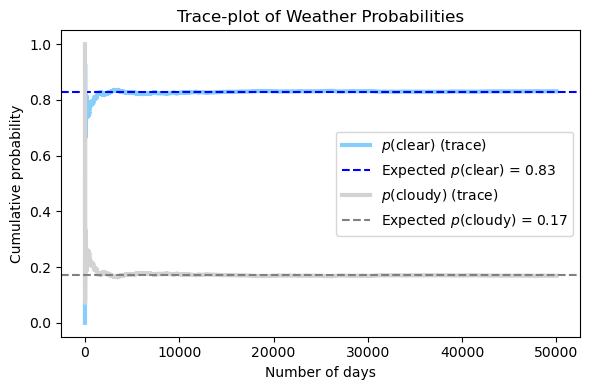

In [5]:
## --- TRACE PLOTS --- ##

fig, ax = plt.subplots(1, 1, figsize=(6,4), layout='tight')

ax.plot(days, cumulative_sunny, color='lightskyblue', linewidth=3, label='$p$(clear) (trace)')
ax.axhline(0.83, linestyle='--', color='goldenrod', linewidth=1.5, label='Expected $p$(clear) = 0.83')

ax.plot(days, cumulative_cloudy, color='lightgray', linewidth=3, label='$p$(cloudy) (trace)')
ax.axhline(0.17, linestyle='--', color='black', linewidth=1.5, label='Expected $p$(cloudy) = 0.17')

ax.set_title('Trace-plot of Weather Probabilities')
ax.set_xlabel('Number of days')
ax.set_ylabel('Cumulative probability')
ax.legend();

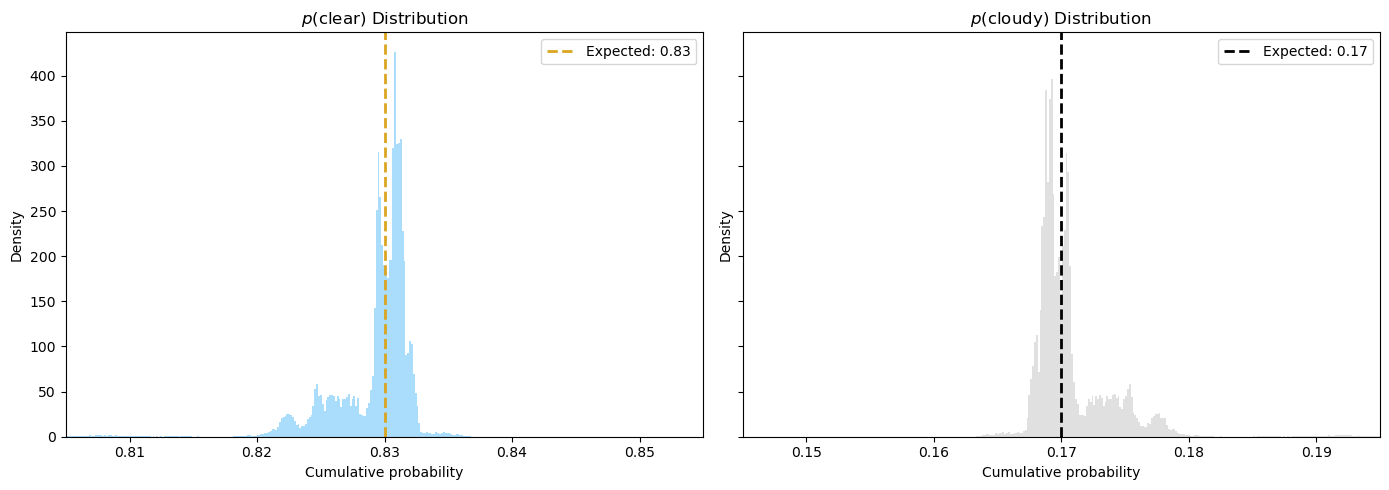

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True, layout='tight')

color = [['lightskyblue', 'goldenrod'], ['lightgray', 'black']]
value = [0.83, 0.17]
title = ['$p$(clear) Distribution', '$p$(cloudy) Distribution']

x = [cumulative_sunny, cumulative_cloudy]

for i, ax in enumerate(axs):
    hist(x[i], bins='freedman', density=True, color=color[i][0], alpha=.7, ax=ax)
    ax.axvline(value[i], color=color[i][1], ls='--', lw=2, label='Expected: ' + str(value[i]))
    ax.set_xlim(value[i] - .025, value[i] + .025)

    ax.set_title(title[i])
    ax.set_xlabel('Cumulative probability')
    ax.set_ylabel('Density')

    ax.legend();

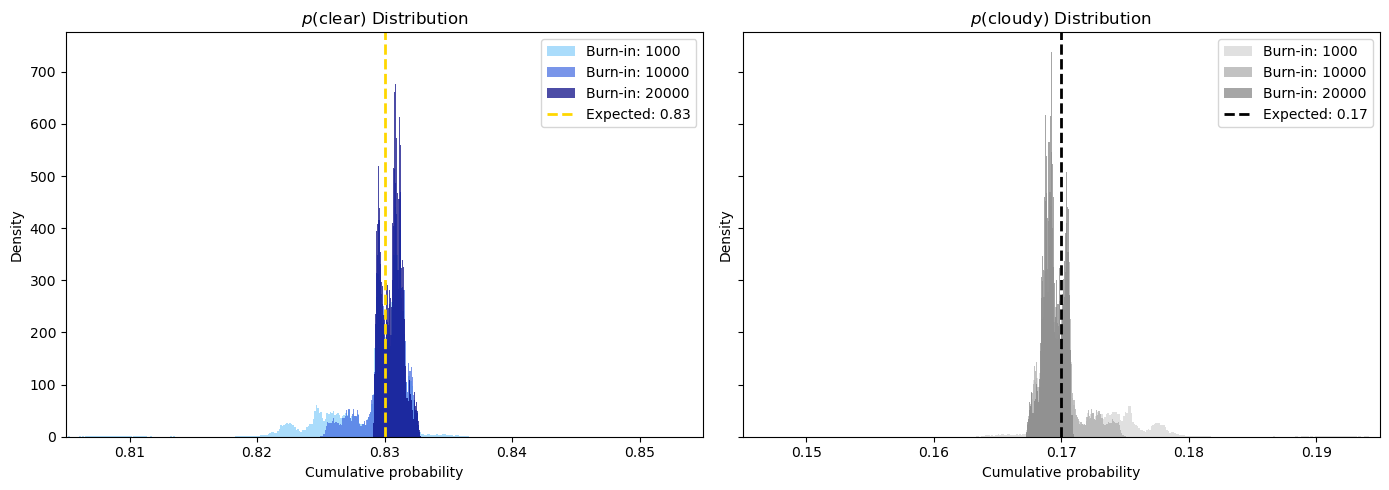

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True, layout='tight')

BURN_IN_VALUES = [1000, 10000, 20000]
color = [['lightskyblue', 'royalblue', 'navy', 'goldenrod'], ['lightgray', 'darkgray', 'gray', 'black']]
value = [0.83, 0.17]
title = ['$p$(clear) Distribution', '$p$(cloudy) Distribution']

x = [cumulative_sunny, cumulative_cloudy]

for i, ax in enumerate(axs):
    for j, burn in enumerate(BURN_IN_VALUES):
        hist(x[i][burn:], bins='freedman', density=True, ax=ax, color=color[i][j], alpha=.7, label='Burn-in: ' + str(burn))
        
    ax.axvline(value[i], color=color[i][-1], ls='--', lw=2, label='Expected: ' + str(value[i]))
    ax.set_xlim(value[i] - .025, value[i] + .025)

    ax.set_title(title[i])
    ax.set_xlabel('Cumulative probability')
    ax.set_ylabel('Density')

    ax.legend();

In [8]:
## --- STATISTICS --- ##

# NOTE: for outliers-heavy datasets median and interquartile range (sigmaG for guassian-like distributions) are better

print(' --- Summary Statistics ---\n')
for burn in BURN_IN_VALUES:
    sunny_data = cumulative_sunny[burn:]
    cloudy_data = cumulative_cloudy[burn:]
    med_sunny = np.median(sunny_data)
    err_sunny = astroMLstats.sigmaG(sunny_data)
    med_cloudy = np.median(cloudy_data)
    err_cloudy = astroMLstats.sigmaG(cloudy_data)
    print(f'Burn-in {burn}:')
    print(f'p(clear)  = {med_sunny:.4f} ± {err_sunny:.4f}')
    print(f'p(cloudy) = {med_cloudy:.4f} ± {err_cloudy:.4f}\n')

 --- Summary Statistics ---

Burn-in 1000:
p(clear)  = 0.8302 ± 0.0016
p(cloudy) = 0.1698 ± 0.0016

Burn-in 10000:
p(clear)  = 0.8306 ± 0.0012
p(cloudy) = 0.1694 ± 0.0012

Burn-in 20000:
p(clear)  = 0.8307 ± 0.0009
p(cloudy) = 0.1693 ± 0.0009

